# Tugas 2: Long Short-term Memory (LSTM)
Oleh:
Rifqi Naufal Abdjul (13520062)
Fachry Dennis Heraldi (13520139) <br>
IF4074 Pembelajaran Mesin Lanjut
Semester Ganjil - Tahun Akademik 2023/2024

## Memuat Modul dan Library yang Digunakan

In [ ]:
!pip install -U -q PyDrive

In [ ]:
import numpy as np # untuk perhitungan matematis
import matplotlib.pyplot as plt # untuk visualisasi
from typing import Union # untuk kebutuhan penulisan tipe data
import json # kebutuhan save and load model
import pandas as pd
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Fungsi Utilitas dalam Implementasi

Berikut ini adalah fungsi-fungsi yang digunakan untuk membantu dalam operasi yang dilakukan pada pengimplementasian.
Fungsi `relu` dan fungsi `sigmoid` berlaku sebagai fungsi aktivasi yang digunakan di dense layer

In [ ]:
@np.vectorize
def relu(x:np.ndarray):
    return np.maximum(0,x)

@np.vectorize
def sigmoid(x:np.ndarray):
    return 1 / (1 + np.exp(-x))

## Implementasi Layer Dense

Kelas `Dense` adalah implementasi dari sebuah fully connected atau dense layer. Di dalam konstruktor (`__init__`), diterima beberapa parameter penting seperti `units`, yang menunjukkan jumlah neuron di layer tersebut, `input_shape`, yang merupakan dimensi dari data masukan, serta `activation`, yang menentukan jenis fungsi aktivasi yang akan digunakan. Variabel-variabel `self.units`, `self.activation`, `self.weights`, `self.bias`, dan `self._input_shape` digunakan untuk menyimpan parameter dan data ini.

Metode `from_file` memungkinkan pembuatan instance dari kelas `Dense` menggunakan parameter yang telah disimpan dalam bentuk dictionary.

Metode `_activation` digunakan untuk menerapkan fungsi aktivasi. Terdapat pilihan antara ReLU, Sigmoid, atau Linear sebagai fungsi aktivasi.

Metode `_compile` digunakan untuk menginisialisasi bobot dan bias. Dipanggil setelah dimensi dari data masukan diketahui. Bobot diinisialisasi sebagai array acak dengan dimensi yang sesuai dengan bentuk masukan dan jumlah unit, sementara bias adalah array acak dengan ukuran yang sama dengan jumlah unit.

Metode `_forward` bertujuan untuk melakukan proses utama. Mengambil tensor masukan, melakukan perkalian matriks dengan bobot, menambahkan bias, dan terakhir menerapkan fungsi aktivasi. Keluaran dari fungsi ini adalah tensor yang telah disesuaikan dimensinya dengan parameter `units`.

Metode `__get_output_shape` mengembalikan bentuk dari tensor keluaran, bertujuan untuk mengetahui bentuk dari data yang akan diteruskan ke layer berikutnya.

In [ ]:
class Dense:
    """ Dense layer.

    Args:
        units: positive integer, dimensionality of the output space
        input_shape: tuple (batch, channel, height, width), shape of input
        received by the dense layer
        activation: string, 'relu' or 'sigmoid'
    """
    def __init__(self,
                 units,
                 input_shape: tuple = None,
                 activation="linear",
                 weights = None,
                 bias = None):
        # units is positive integer
        if not(isinstance(units, int) and units > 0):
            raise ValueError("Invalid units. Must be a positive integer.")

        # activation is either 'ReLU' or 'sigmoid'
        if activation not in ["relu", "sigmoid", "linear"]:
            raise ValueError(
                "Invalid activation. Must be either 'relu' or 'sigmoid' or 'linear'."
            )

        self.units = units
        self.activation = activation
        self.weights = weights
        self.bias = bias
        self._input_shape = input_shape
        self._is_compiled = False

    @classmethod
    def from_file(cls, params):
        kernel = np.array(params['kernel'])
        bias = np.array(params['bias'])
        return cls(
            units = kernel.shape[1],
            input_shape = (1,kernel.shape[0]),
            weights = kernel,
            bias = bias
        )

    def __call__(self, x):
        self.input = x
        return self._forward(x)

    def _activation(self, x):
        if self.activation == "relu":
            return relu(x)
        elif self.activation == "sigmoid":
            return sigmoid(np.float128(x))
        elif self.activation == "linear":
            return x

    def _compile(self, input_shape: tuple = None, random=True):
        if input_shape is not None:
            assert input_shape[-2] == 1, "Input must be 1D for dense layer"
            self._input_shape = np.array(input_shape)

        if random:
            self.weights = np.random.randn(self._input_shape[-1], self.units)
            self.bias = np.random.randn(self.units)
        self._is_compiled = True

    def _forward(self, x):
        assert self._is_compiled, "Layer is not compiled"
        # x is N-D tensor with 2D shape (batch_size, input_dim)
        self.x = x

        # Calculate output tensor
        self.y = np.dot(x, self.weights) + self.bias
        # x_dense shape dimension (batch_size, units)
        return self._activation(self.y)

    def __get_output_shape(self):
        return (1, self.units)

    def __get_param_count(self):
        return ((self._input_shape[0]*self._input_shape[1] + 1) * self.units)

    output_shape = property(__get_output_shape)
    param_count = property(__get_param_count)

## Implementasi Layer LSTM

Kelas `LSTM` adalah kelas yang mengimplementasikan model Long Short-Term Memory. Di awal, kelas diinisialisasi dengan parameter seperti `units`, yang mendefinisikan jumlah neuron atau unit di dalam LSTM. Parameter `input_shape` mendefinisikan bentuk dari input yang akan diberikan ke layer ini, sedangkan `weights` berisi bobot dari layer yang bisa disediakan pada saat inisialisasi atau dihasilkan secara otomatis kemudian.

Selanjutnya, metode `from_file` memungkinkan pembuatan instance dari kelas LSTM menggunakan parameter yang telah disimpan dalam bentuk dictionary. Ini sangat berguna terutama saat ingin memuat model yang telah dilatih sebelumnya. Ketika layer dipanggil dengan suatu input, metode `__call__` akan menginisialisasi hidden state dan cell state, lalu melaksanakan operasi forward propagation untuk setiap timestep pada input yang diberikan.

Salah satu metode penting lainnya adalah `_compile`, yang berfungsi untuk menginisialisasi atau mengatur ulang bobot layer berdasarkan bentuk input dan metode inisialisasi bobot yang diinginkan, apakah secara acak atau dengan pola tertentu. Namun, inti dari operasi LSTM terdapat pada metode `_forward`. Di sini, semua operasi internal layer LSTM, seperti forget gate, input gate, cell state, dan output gate, dijalankan untuk memutuskan informasi apa yang harus dilupakan, diperbarui, atau ditampilkan dari cell state ke hidden state.

Untuk membantu di luar kelas, ada metode `__get_output_shape` yang mengembalikan bentuk dari output layer dan `__get_param_count` yang menghitung total parameter yang digunakan oleh layer. Jumlah parameter ini penting untuk dipahami karena berkaitan dengan kompleksitas model dan kapasitasnya untuk mempelajari fitur dari data.

In [ ]:
class LSTM:
    def __init__(self, units, input_shape: tuple = None, weights=None):
        # units is positive integer
        if not(isinstance(units, int) and units > 0):
            raise ValueError("Invalid units. Must be a positive integer.")

        self.units = units
        self.weights = weights
        self._input_shape = input_shape
        self._is_compiled = False

    @classmethod
    def from_file(cls, params):
        weights = {}
        for param, value in params.items():
            weights[param] = np.array(value)
        input_shape, units = weights['W_f'].shape
        return cls(
            units = units,
            input_shape = (1, input_shape),
            weights = weights
        )

    def __call__(self, x):
        self._h_prev = np.zeros(self.units)
        self._c_prev = np.zeros(self.units)
        self.input = x # (x's shape = (timestep, features))
        for i in range(len(x)):
          self._forward(x[i])
        return self._h_prev

    def _compile(self, input_shape: tuple = None, random=True):
        if input_shape is not None:
            assert input_shape[-2] == 1, "Input must be 1D for dense layer"
            self._input_shape = np.array(input_shape)

        input_size = self._input_shape[-1]

        if self.weights is None:
          self.weights = {}
          if random:
              for key in ['W_f', 'W_i', 'W_c', 'W_o']:
                self.weights[key] = np.random.randn(self.units, input_size)
              for key in ['U_f', 'U_i', 'U_c', 'U_o']:
                self.weights[key] = np.random.randn(self.units, self.units)
              for key in ['b_f', 'b_i', 'b_c', 'b_o']:
                self.weights[key] = np.random.randn(self.units, 1)
          else:
              for key in ['W_f', 'W_i', 'W_c', 'W_o']:
                self.weights[key] = np.arange(self.units * input_size).reshape(self.units, input_size)
              for key in ['U_f', 'U_i', 'U_c', 'U_o']:
                self.weights[key] = np.arange(self.units * self.units).reshape(self.units, self.units)
              for key in ['b_f', 'b_i', 'b_c', 'b_o']:
                self.weights[key] = np.arange(self.units).reshape(self.units,1)

        self._h_prev = np.zeros(self.units)
        self._c_prev = np.zeros(self.units)
        self._is_compiled = True

    def _forward(self, x):
        assert self._is_compiled, "Layer is not compiled"

        ft = sigmoid(np.dot(self.weights['W_f'].T, x) + np.dot(self.weights['U_f'], self._h_prev) + self.weights['b_f'])

        it = sigmoid(np.dot(self.weights['W_i'].T, x) + np.dot(self.weights['U_i'], self._h_prev) + self.weights['b_i'])

        ct = np.tanh(np.dot(self.weights['W_c'].T, x) + np.dot(self.weights['U_c'], self._h_prev) + self.weights['b_c'])

        ot = sigmoid(np.dot(self.weights['W_o'].T, x) + np.dot(self.weights['U_o'], self._h_prev) + self.weights['b_o'])

        self._c_prev = ft * self._c_prev +  ct
        self._h_prev = ot * np.tanh(self._c_prev)

        return self._h_prev

    def __get_output_shape(self):
        return (1, self.units)

    def __get_param_count(self):
        x = self._input_shape[-1]
        h = self.units
        return (4*((x+h)*h+h))

    output_shape = property(__get_output_shape)
    param_count = property(__get_param_count)

## Implementasi Model Sequential

Kelas `Sequential` adalah kelas untuk mengelompokkan serangkaian layer secara linear ke dalam sebuah model pembelajaran. Kelas ini menyediakan metode untuk mengompilasi model, merangkum arsitekturnya, dan melakukan prediksi, meskipun metode untuk pelatihan (`fit`) dan evaluasi (`evaluate`) hanya didefinisikan tetapi belum diimplementasikan.

Metode `__init__` adalah konstruktor yang menginisialisasi sebuah daftar kosong bernama `self.layers` dan menambahkan layer ke dalamnya jika ada yang disediakan saat pembuatan objek. Metode `compile` memastikan bahwa model memiliki layer dan layer pertama memiliki bentuk masukan yang ditentukan. Metode ini memanggil metode `_compile` pada setiap layer. Jika tanda `random` diatur ke `True`, bobot layer akan diinisialisasi secara acak.

Metode `summary` mencetak arsitektur dan jumlah parameter dari setiap layer di model. Metode ini menghitung jumlah total parameter di model sebagai `total_params`.

Metode `predict` menerima sebuah array NumPy sebagai masukan, memeriksa apakah bentuknya sesuai dengan bentuk masukan layer pertama, dan meneruskannya melalui semua layer di model. Variabel `self.layers` adalah daftar yang memegang semua layer dalam model, dan `total_params` adalah variabel untuk melacak jumlah total parameter di semua layer, yang digunakan dalam metode `summary`.

Metode `save` menerima nama file yang akan diberikan untuk menyimpan model dalam format JSON. Sebaliknya, metode `load` menerima nama file eksternal dalam format JSON untuk memuat informasi parameter tiap layer pada model yang disimpan pada file tersebut ke dalam objek model `Sequential`.

In [ ]:
class Sequential:
    """ Sequential class.
    Sequential groups a linear stack of layers into a model
    Sequential provides training and inference features on this model.
    """
    def __init__(self, *layers):
        self.layers = []
        for l in layers:
            self.layers.append(l)

    def add(self, layer):
        self.layers.append(layer)

    def compile(self, random=True):
        assert len(self.layers) > 0, "No layers are available"
        assert self.layers[0]._input_shape is not None, "First layer needs an input shape"

        self.layers[0]._compile(random=random)
        for i in range(len(self.layers) - 1):
            self.layers[i+1]._compile(self.layers[i].output_shape, random=random)

    def summary(self):
        print('Model: "sequential"')
        print("-"*70)
        print("{:<20}{:<30}{:<20}".format("Layer (type)", "Output Shape", "Param #"))
        print("="*70)
        total_params = 0
        # Looping per layer
        for layer in self.layers:
            total_params+=layer.param_count
            print('{:<20}{:<30}{:<20}'.format(type(layer).__name__, str(layer.output_shape), layer.param_count))
        print("="*70)
        print(f"Total params: {total_params}")
        print(f"Trainable params: {total_params}")
        print(f"Non-trainable params: 0")

    def predict(self, inp: np.ndarray):
        result = inp.copy()
        for layer in self.layers:
            result = layer(result)
        return result

    def save(self, filename):
        data = []
        for layer in self.layers:
          if layer.__class__.__name__ == 'LSTM':
            weights = {}
            for key in layer.weights:
              weights[key] = layer.weights[key].tolist()
            data.append({
                "type": "lstm",
                "params": weights
            })
          elif layer.__class__.__name__ == 'Dense':
            data.append({
                "type": "dense",
                "params": {
                    "kernel": layer.weights.tolist(),
                    "bias": layer.bias.tolist()
                }
            })

        with open(filename, "w") as file:
          json.dump(data, file)

    def load(self, filename):
        self.layers = []
        with open(filename, "r") as file:
            models = json.load(file)
        for model in models:
          if model['type'] == 'lstm':
            self.add(
                LSTM.from_file(model['params'])
            )
          elif model['type'] == 'dense':
            self.add(
                Dense.from_file(model['params'])
            )


## Contoh Hasil Prediksi Menggunakan Model LSTM yang Dibuat

### Mengambil File Dataset dan Trained Model

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1TG6YYGc1a252MNsyvMJPlloZ6CEf5BHX' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: Train_stock_market.csv, id: 161zosFN434JGf0D4ssvzHOOh2P2iv5Rl
downloading to Train_stock_market.csv
title: Test_stock_market.csv, id: 1YhhX5wilhflUfDbqBI3rpcY0s0nZqeSU
downloading to Test_stock_market.csv
title: model_4_parameters.json, id: 1kA6u0fx536TqyfVSb1AaT5q9l9TE6ZPf
downloading to model_4_parameters.json


### Load Dataset

In [ ]:
train_data = pd.read_csv('Train_stock_market.csv')
test_data = pd.read_csv('Test_stock_market.csv')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9645 entries, 0 to 9644
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            9645 non-null   object 
 1   Low             9645 non-null   float64
 2   Open            9645 non-null   float64
 3   Volume          9645 non-null   int64  
 4   High            9645 non-null   float64
 5   Close           9645 non-null   float64
 6   Adjusted Close  9645 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 527.6+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       39 non-null     object 
 1   Open       39 non-null     float64
 2   High       39 non-null     float64
 3   Low        39 non-null     float64
 4   Close      39 non-null     float64
 5   Adj Close  39 non-null     float64
 6   Volume     39 non-null     int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 2.3+ KB


###  Inisialisasi Jaringan LSTM

In [ ]:
# Inisialisasi object Sequential
model = Sequential()

In [ ]:
# Load pre-trained model
model.load("model_4_parameters.json")

In [ ]:
# Compile model
model.compile(random=False)

In [ ]:
# Melihat trainable parameters dari summary model
model.summary()

Model: "sequential"
----------------------------------------------------------------------
Layer (type)        Output Shape                  Param #             
LSTM                (1, 64)                       17920               
Dense               (1, 5)                        325                 
Total params: 18245
Trainable params: 18245
Non-trainable params: 0


### Prediksi Beberapa Data Uji

In [ ]:
# Pemilihan fitur yang ingin diprediksi: High, Low, Volume, Open, Close
train_data_features = train_data[['High','Low','Volume','Open', 'Close']]
test_data_features = test_data[['High','Low','Volume','Open', 'Close']]

In [ ]:
# Normalisasi data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data_features)
scaled_test = scaler.transform(test_data_features)

In [ ]:
def create_sequences(data, seq_length):
  sequences = []
  targets = []
  data_len = len(data)
  for i in range(data_len - seq_length):
    seq_end = i + seq_length
    seq_x = data[i:seq_end]
    seq_y = data[seq_end]
    sequences.append(seq_x)
    targets.append(seq_y)
  return np.array(sequences), np.array(targets)

In [ ]:
def predict_by_sequence(model, data, scaler, scaled_data_arr, seq_length):
  sequences, targets = create_sequences(scaled_data_arr, seq_length)
  predictions = []
  for seq in sequences:
    pred = model.predict(seq)
    predictions.append(pred)
  error = mean_squared_error(targets, predictions)
  pred_length = len(predictions)
  predictions = scaler.inverse_transform(predictions)
  predictions = predictions.T

  data = data[['Date','High','Low','Volume','Open', 'Close']]
  data = data.tail(pred_length)
  data['Pred High'] = predictions[0]
  data['Pred Low'] = predictions[1]
  data['Pred Volume'] = predictions[2]
  data['Pred Open'] = predictions[3]
  data['Pred Close'] = predictions[4]

  plt.figure(figsize=(14, 7))
  plt.plot(data['Date'], data['High'], label='Actual High Price')
  plt.plot(data['Date'], data['Low'], label='Actual Low Price')
  plt.plot(data['Date'], data['Open'], label='Actual Open Price')
  plt.plot(data['Date'], data['Close'], label='Actual Close Price')
  plt.plot(data['Date'], data['Pred High'], label='Predicted High Price')
  plt.plot(data['Date'], data['Pred Low'], label='Predicted Low Price')
  plt.plot(data['Date'], data['Pred Open'], label='Predicted Open Price')
  plt.plot(data['Date'], data['Pred Close'], label='Predicted Close Price')

  plt.title(f'Stock Market Price Over The Time (Predicted using {seq_length} Sequence Length)')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.grid(True)
  plt.xticks(data['Date'][::1])  # Show every date for clarity
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(14, 7))
  plt.plot(data['Date'], data['Volume'], label='Actual Volume')
  plt.plot(data['Date'], data['Pred Volume'], label='Predicted Volume')
  plt.title(f'Stock Market Volume Over The Time (Predicted using {seq_length} Sequence Length)')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.grid(True)
  plt.xticks(data['Date'][::1])  # Show every date for clarity
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()
  print(f"RMSE: {error} ")

#### Eksperimen Prediksi Data Uji dengan Panjang Sekuens 2

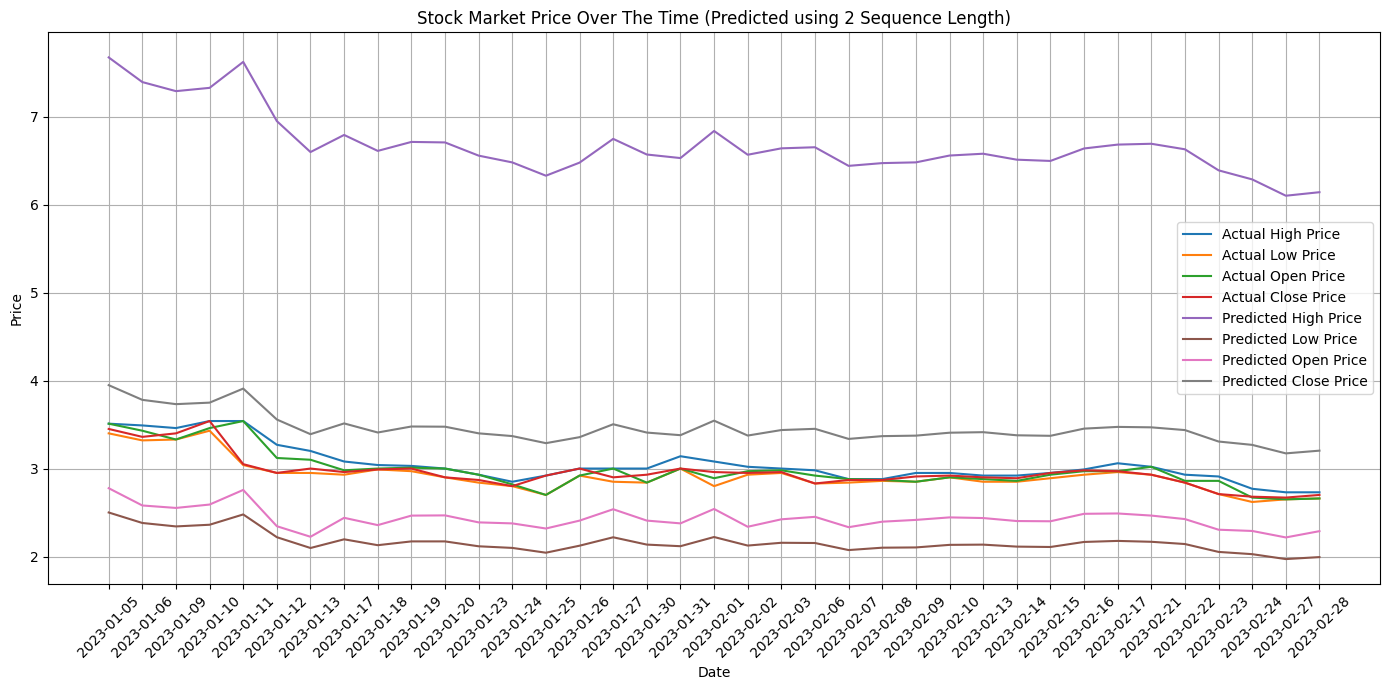

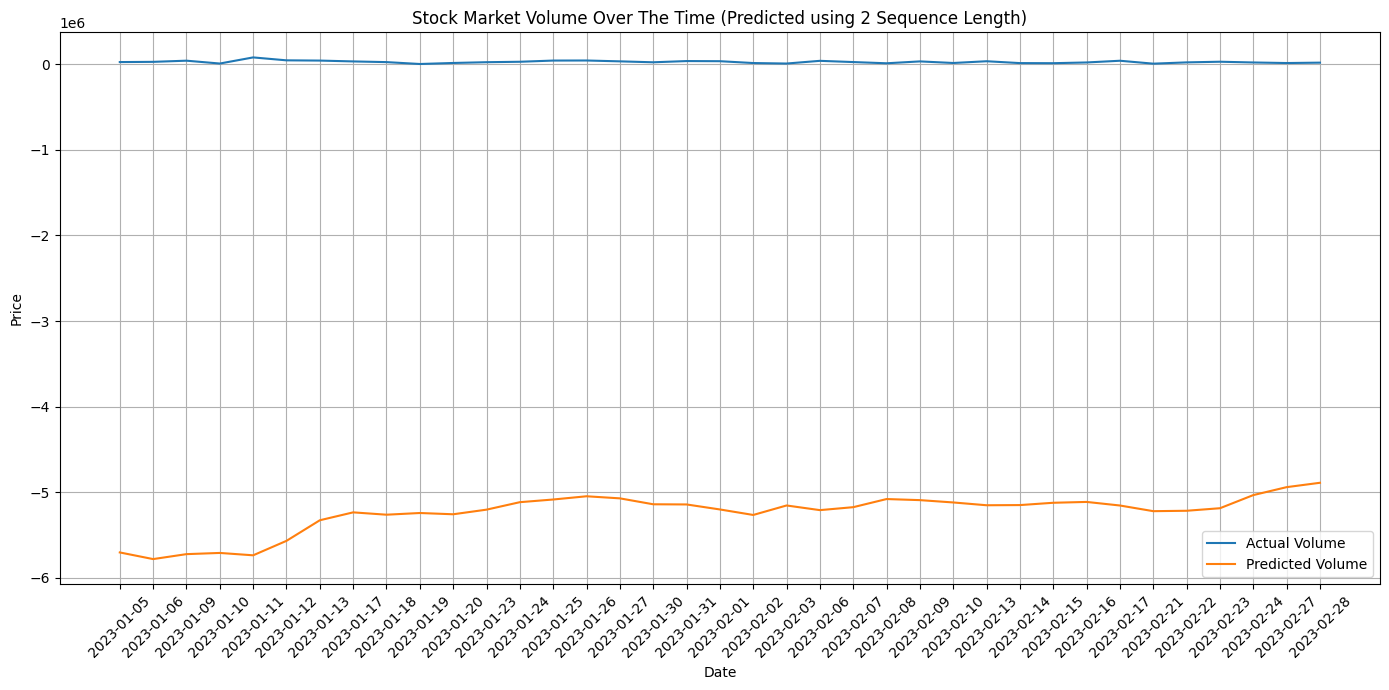

RMSE: 0.0065556796913000025 


In [ ]:
predict_by_sequence(model, test_data, scaler, scaled_test, 2)

#### Eksperimen Prediksi Data Uji dengan Panjang Sekuens 4

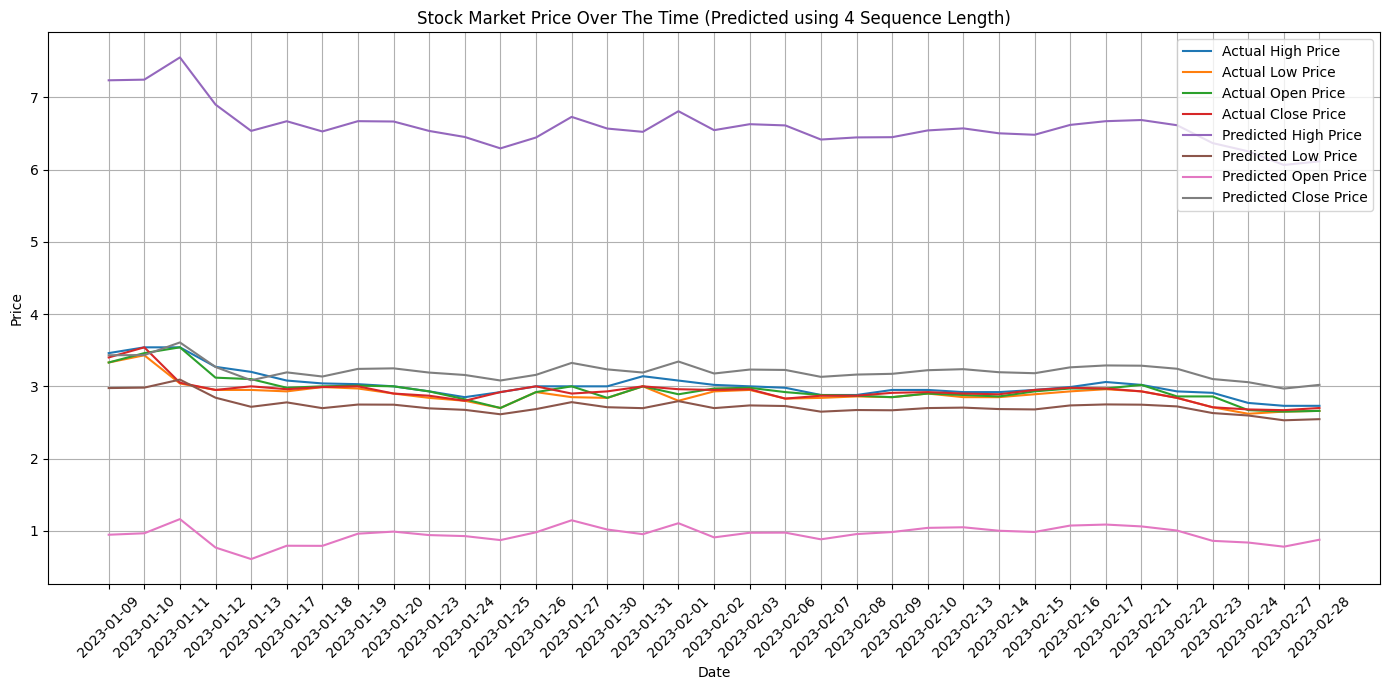

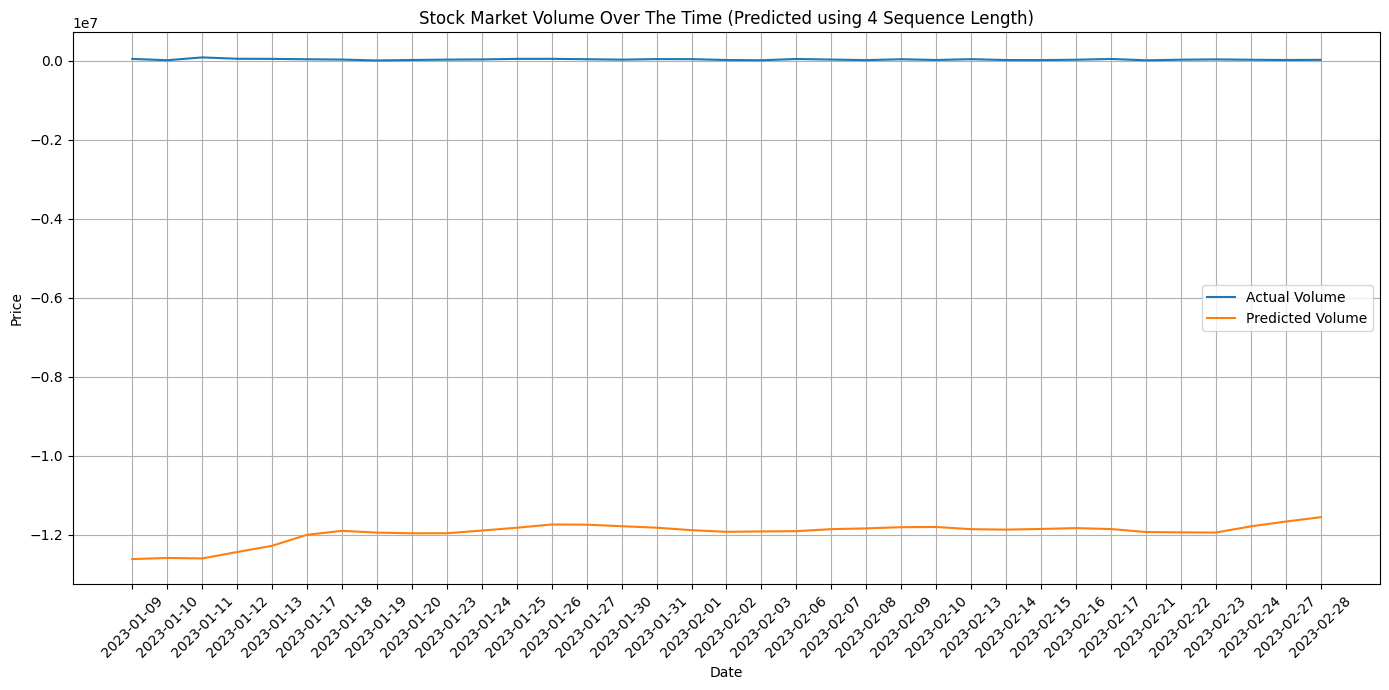

RMSE: 0.010154455720784841 


In [ ]:
predict_by_sequence(model, test_data, scaler, scaled_test, 4)

#### Eksperimen Prediksi Data Uji dengan Panjang Sekuens 8

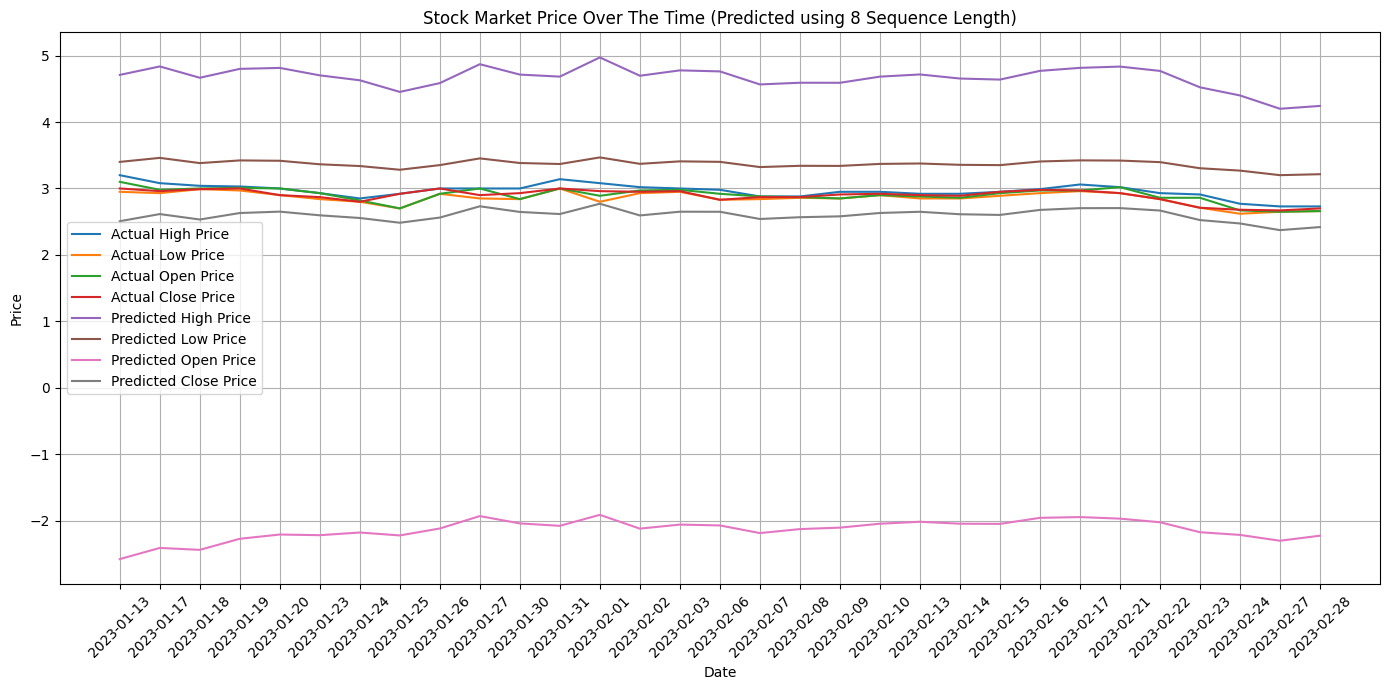

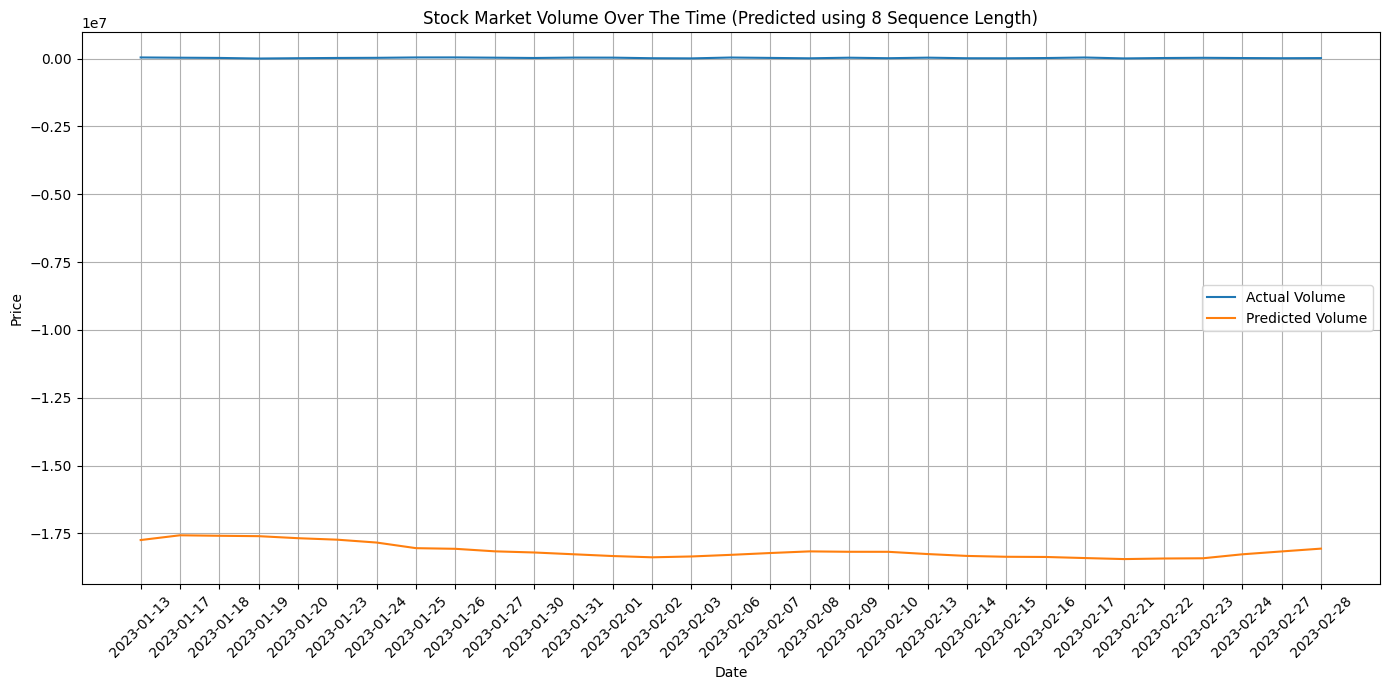

RMSE: 0.02190130718208759 


In [ ]:
predict_by_sequence(model, test_data, scaler, scaled_test, 8)

### Save Model

In [ ]:
# Save the model
model = Sequential()
model.load("model_4_parameters.json")
model.save("model_4_parameters_new.json")

In [ ]:
# Try to load the saved model, and compare the summary
model2 = Sequential()
model2.load("model_4_parameters_new.json")
model.summary(), print(), model2.summary()

Model: "sequential"
----------------------------------------------------------------------
Layer (type)        Output Shape                  Param #             
LSTM                (1, 64)                       17920               
Dense               (1, 5)                        325                 
Total params: 18245
Trainable params: 18245
Non-trainable params: 0

Model: "sequential"
----------------------------------------------------------------------
Layer (type)        Output Shape                  Param #             
LSTM                (1, 64)                       17920               
Dense               (1, 5)                        325                 
Total params: 18245
Trainable params: 18245
Non-trainable params: 0


(None, None, None)

In [ ]:
# Making sure, the json is same
with open("model_4_parameters.json", "r") as f:
  a = json.load(f)

with open("model_4_parameters_new.json", "r") as f:
  b = json.load(f)

str(a) == str(b)

True

## Pembagian Tugas

Rifqi Naufal Abdjul (13520062) mengerjakan implementasi LSTM, perhitungan summary model, dan save model.

Fachry Dennis Heraldi (13520139) mengerjakan implementasi prediksi model, penggunaan model, dan load model.

## Kesimpulan Hasil Eksperimen


Dalam rangka menjalankan serangkaian eksperimen, kami telah melakukan prediksi terhadap kolom 'High', 'Low', 'Volume', 'Open', dan 'Close' dalam data uji dengan variasi panjang sekuens: 2, 4, dan 8. Untuk memulai eksperimen ini, bobot pada model awalnya diinisialisasi dengan memuat file 'model_4_parameters.json'.

Pendekatan eksperimental yang kami terapkan adalah dengan mengambil x data pertama, di mana x adalah panjang sekuens yang ditentukan. Data-data awal ini digunakan untuk memprediksi data berikutnya, yaitu data ke-x+1. Dalam dataset uji kami yang terdiri dari 39 baris data, ini berarti untuk panjang sekuens 2, kami memprediksi 37 data, untuk panjang sekuens 4, kami memprediksi 35 data, dan untuk panjang sekuens 8, kami memprediksi 31 data.

Penting untuk dicatat bahwa perbedaan dalam panjang sekuens pada setiap eksperimen memengaruhi nilai h (hidden state) dan c (cell state) yang dihasilkan setelah proses forward pass melalui x data pertama, yang pada gilirannya digunakan untuk memprediksi data ke-x+1.

Namun, perlu diperhatikan dari hasil eksperimen yang kami peroleh, model belum mampu memprediksi data dengan akurasi yang memuaskan. Hal ini dapat dijelaskan oleh keterbatasan model kami dalam memahami dan mengekstraksi pola dari data latih, karena model kami tidak memiliki mekanisme backpropagation. Sebagai gantinya, hasil prediksi kami bergantung pada bobot yang dimuat dari file eksternal, yang mungkin belum mencerminkan informasi yang cukup untuk prediksi yang akurat. Dalam perkembangan selanjutnya, perbaikan dan pengembangan model mungkin diperlukan untuk meningkatkan performa prediksi kami.